# **PRE-TRAINED VISION TRANSFORMER**

In [5]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras.layers as L
import tensorflow_addons as tfa
import glob, random, os, warnings
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

print('TensorFlow Version ' + tf.__version__)

def seed_everything(seed = 0):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

seed_everything()

import warnings
warnings.filterwarnings("ignore")
image_size = 224
batch_size = 16
n_classes = 4
EPOCHS = 50

TensorFlow Version 2.14.1


In [7]:
import tensorflow_addons as tfa
print(tfa.__version__)  # Should print 0.19.0


0.22.0


In [9]:
import tensorflow as tf
print(tf.__version__)


2.14.1


In [11]:
import numpy as np
print(np.__version__)


1.24.3


In [13]:
import pandas as pd
IMAGE_PATH = '../dataset/dataset.tsv'  # Update with your path

In [15]:
df_img = pd.read_csv(IMAGE_PATH, sep="\t")
# Clean the columns
df_img = (df_img.rename(columns={'Unnamed: 0': 'spot_id'})  # Rename first column
           .drop(columns=['cm'])  # Remove cm column
           .set_index('spot_id').astype(str))

# Verify changes
df_img.head()

img  \
spot_id                                                                     
CN51_C2_2_1.996x25.956  ../dataset/tile\CN51_C2_2\CN51_C2_2-1.996-25.9...   
CN51_C2_2_2.004x26.954  ../dataset/tile\CN51_C2_2\CN51_C2_2-2.004-26.9...   
CN51_C2_2_2.006x31.917  ../dataset/tile\CN51_C2_2\CN51_C2_2-2.006-31.9...   
CN51_C2_2_2.007x29.936  ../dataset/tile\CN51_C2_2\CN51_C2_2-2.007-29.9...   
CN51_C2_2_2.007x32.938  ../dataset/tile\CN51_C2_2\CN51_C2_2-2.007-32.9...   

                       label  
spot_id                       
CN51_C2_2_1.996x25.956   p70  
CN51_C2_2_2.004x26.954   p70  
CN51_C2_2_2.006x31.917   p70  
CN51_C2_2_2.007x29.936   p70  
CN51_C2_2_2.007x32.938   p70

In [17]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import cv2  # Importing OpenCV

# Extract image paths and labels from the CSV file
image_paths = df_img['img'].values  # Assuming 'img' column has the image paths
labels = df_img['label'].values  # Assuming 'label' column has the labels

# Encode labels
label_encoder = LabelEncoder()
y_labels = label_encoder.fit_transform(labels)

# Load and normalize full images before feeding into ViT
def load_images(image_paths, target_size=(224, 224)):  # Changed to 224x224
    images = []
    for img_path in image_paths:
        # Read image using OpenCV (returns BGR)
        img = cv2.imread(img_path)
        
        # Convert from BGR to RGB (OpenCV loads images as BGR by default)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Resize the image to the target size
        img = cv2.resize(img, target_size)  # Resize using OpenCV
        
        # Normalize to [0,1]
        img = img / 255.0
        images.append(img)
        
    return np.array(images, dtype=np.float32)  # Ensure correct dtype

# Load images
X_images_full2 = load_images(image_paths)

# Convert labels to NumPy array (ensures compatibility)
y_labels2 = np.array(y_labels, dtype=np.int32)  

# Train-test split (60% train, 40% temp)
X_train_full2, X_temp_full2, y_train2, y_temp2 = train_test_split(
    X_images_full2, y_labels2, test_size=0.4, random_state=42, stratify=y_labels2
)

# Split temp into validation (20%) and test (10%) → validation = 2/3 of temp, test = 1/3
X_val_full2, X_test_full2, y_val2, y_test2 = train_test_split(
    X_temp_full2, y_temp2, test_size=1/4, random_state=42, stratify=y_temp2
)

# Print dataset shapes
print("Shapes:")
print("Train:", X_train_full2.shape, y_train2.shape)
print("Validation:", X_val_full2.shape, y_val2.shape)
print("Test:", X_test_full2.shape, y_test2.shape)


Shapes:
Train: (1268, 224, 224, 3) (1268,)
Validation: (634, 224, 224, 3) (634,)
Test: (212, 224, 224, 3) (212,)


In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the image augmentation function
def augment_images(X_train, y_train, X_val, y_val, X_test, y_test):
    # Create ImageDataGenerators for augmentation (only for training data)
    train_datagen = ImageDataGenerator(
        rotation_range=30,  
        width_shift_range=0.2,  
        height_shift_range=0.2,  
        shear_range=0.2,  
        zoom_range=0.2,  
        horizontal_flip=True,  
        fill_mode='reflect'  
    )

    val_test_datagen = ImageDataGenerator()  # No augmentation for validation and test data

    # Create data generators from the numpy arrays
    train_generator = train_datagen.flow(X_train, y_train, batch_size=32)
    val_generator = val_test_datagen.flow(X_val, y_val, batch_size=32)
    test_generator = val_test_datagen.flow(X_test, y_test, batch_size=32)

    return train_generator, val_generator, test_generator

# Ensure y_train_full2, y_val_full2, and y_test_full2 are defined
train_generator, val_generator, test_generator = augment_images(
    X_train_full2, y_train2, X_val_full2, y_val2, X_test_full2, y_test2
)


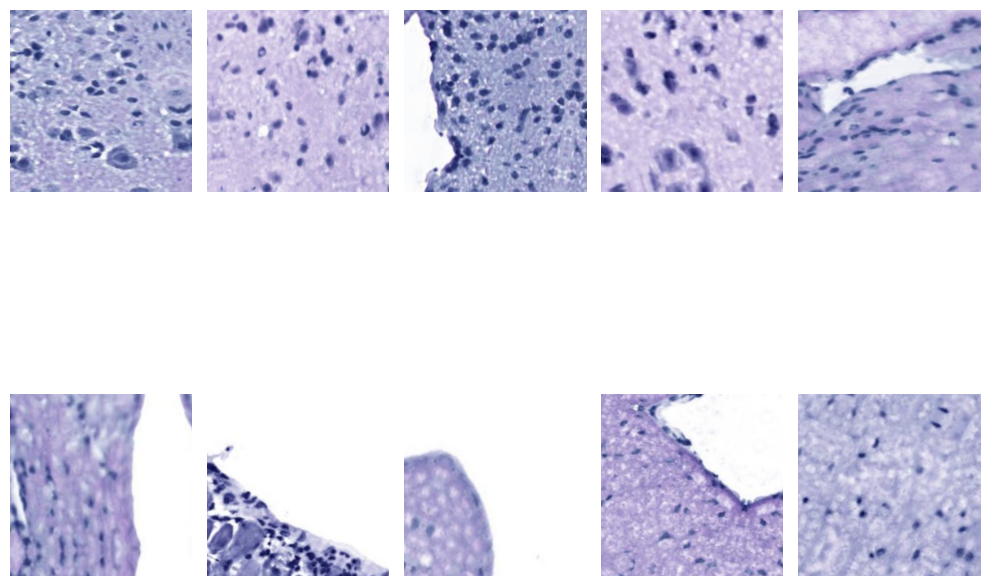

In [19]:
import warnings
import matplotlib.pyplot as plt
import scipy


# Ignore warnings
warnings.filterwarnings("ignore")

# Extract 16 images from the first batch of the training generator
images = [train_generator[0][0][i] for i in range(16)]  # Get 16 images from the first batch
image_size = 224  # Assuming the images are 224x224, update if necessary

# Set up the figure and axes for the grid of images
fig, axes = plt.subplots(2, 5, figsize=(10, 10))  # 2 rows, 5 columns
axes = axes.flatten()  # Flatten the axes array for easy iteration

# Loop through the images and plot them
for img, ax in zip(images, axes):
    img = (img * 255).astype("uint8")  # Scale pixel values to 0-255
    ax.imshow(img)  
    ax.axis('off')


# Adjust layout and display the plot
plt.tight_layout()
plt.show()


In [20]:
from vit_keras import vit

vit_model = vit.vit_b16(
        image_size = image_size,
        activation = 'softmax',
        pretrained = True,
        include_top = False,
        pretrained_top = False,
        classes = 5)

In [21]:
class Patches(L.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images = images,
            sizes = [1, self.patch_size, self.patch_size, 1],
            strides = [1, self.patch_size, self.patch_size, 1],
            rates = [1, 1, 1, 1],
            padding = 'VALID',
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Image size: 224 X 224
Patch size: 7 X 7
Patches per image: 1024
Elements per patch: 147


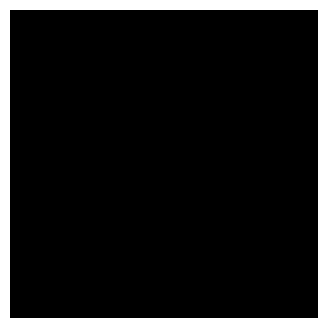

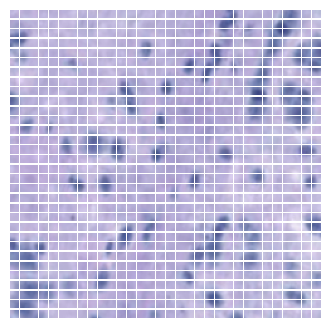

In [22]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
batch_size = 16
patch_size = 7  # Size of the patches to be extracted from the input images
image_size = 224  # Define the image size
num_patches = (image_size // patch_size) ** 2

x = train_generator.next()
image = x[0][0]  # Extract a single image from the batch

plt.imshow(image.astype('uint8'))
plt.axis('off')

# Ensure the image is resized to the correct dimensions
resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)

# Extract patches
patches = Patches(patch_size)(resized_image)
print(f'Image size: {image_size} X {image_size}')
print(f'Patch size: {patch_size} X {patch_size}')
print(f'Patches per image: {patches.shape[1]}')
print(f'Elements per patch: {patches.shape[-1]}')

# Calculate grid size for visualization
n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))

for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)

    # Reshape and scale the patch back to [0,255]
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))  # Ensure correct shape
    patch_img = tf.clip_by_value(patch_img, 0, 1)  # Ensure values are within [0,1]
    patch_img = (patch_img * 255).numpy().astype('uint8')  # Scale back to [0,255]

    plt.imshow(patch_img)
    plt.axis('off')

plt.show()


In [23]:

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.regularizers import l2

model_1 = tf.keras.Sequential([
    vit_model, 
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Dense(128, activation=tfa.activations.gelu, kernel_regularizer=l2(1e-4)),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(64, activation=tfa.activations.gelu, kernel_regularizer=l2(1e-4)),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(32, activation=tfa.activations.gelu, kernel_regularizer=l2(1e-4)),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Dense(4, activation='softmax') 
])

model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit-b16 (Functional)        (None, 768)               85798656  
                                                                 
 batch_normalization (Batch  (None, 768)               3072      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 128)               98432     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 batch_normalization_1 (Bat  (None, 128)               512       
 chNormalization)                                                
                                                                 
 dense_1 (Dense)             (None, 64)                8

In [24]:
learning_rate = 1e-5
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model_1.compile(optimizer=optimizer, 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

STEP_SIZE_TRAIN = train_generator.n // train_generator.batch_size
STEP_SIZE_VALID = val_generator.n // val_generator.batch_size

early_stopping_callbacks = tf.keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True, verbose=1)

model_1.fit(x=train_generator,
          steps_per_epoch=STEP_SIZE_TRAIN,
          validation_data=val_generator,
          validation_steps=STEP_SIZE_VALID,
          epochs=EPOCHS,
          callbacks=[early_stopping_callbacks])

Epoch 1/50
39/39 [==============================] - 616s 15s/step - loss: 1.5348 - accuracy: 0.3074 - val_loss: 1.3276 - val_accuracy: 0.4030
Epoch 2/50
39/39 [==============================] - 455s 12s/step - loss: 1.4774 - accuracy: 0.3285 - val_loss: 1.2390 - val_accuracy: 0.4852
Epoch 3/50
39/39 [==============================] - 379s 10s/step - loss: 1.3969 - accuracy: 0.3697 - val_loss: 1.1811 - val_accuracy: 0.5280
Epoch 4/50
39/39 [==============================] - 376s 10s/step - loss: 1.3367 - accuracy: 0.4215 - val_loss: 1.1172 - val_accuracy: 0.5592
Epoch 5/50
39/39 [==============================] - 367s 9s/step - loss: 1.2429 - accuracy: 0.4506 - val_loss: 1.0108 - val_accuracy: 0.6349
Epoch 6/50
39/39 [==============================] - 364s 9s/step - loss: 1.1533 - accuracy: 0.5186 - val_loss: 0.9303 - val_accuracy: 0.6727
Epoch 7/50
39/39 [==============================] - 357s 9s/step - loss: 1.0962 - accuracy: 0.5461 - val_loss: 0.8330 - val_accuracy: 0.7023
Epoch 8/5

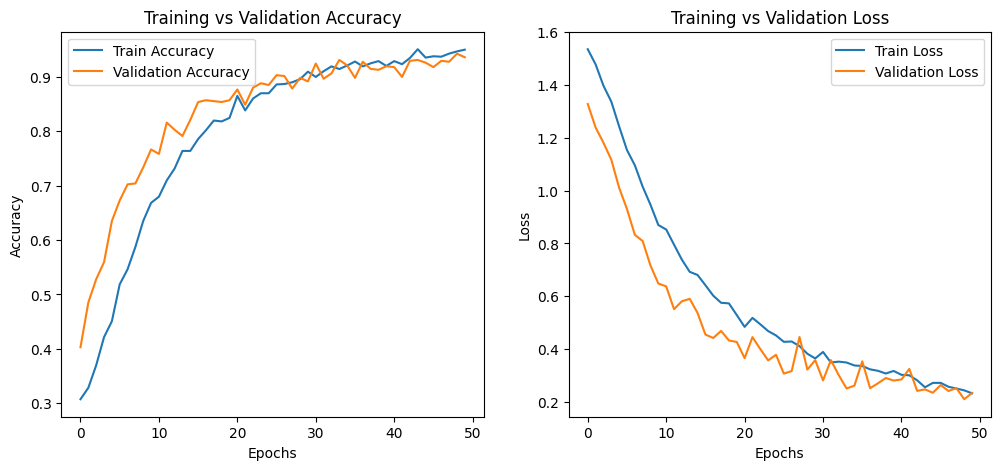

In [33]:
# Extract history from model
history = model_1.history.history  # model.history stores the training history



# Plot Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history['accuracy'], label='Train Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history['loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()

plt.show()

In [67]:
from tensorflow.keras.models import load_model

model = load_model("my_model.keras", safe_mode=False)



In [41]:
# Get test predictions
y_pred = model_1.predict(test_generator)
confidence = np.max(y_pred, axis=1)
print(f"Average prediction confidence: {np.mean(confidence):.2f}")

7/7 [==============================] - 20s 3s/step
Average prediction confidence: 0.95


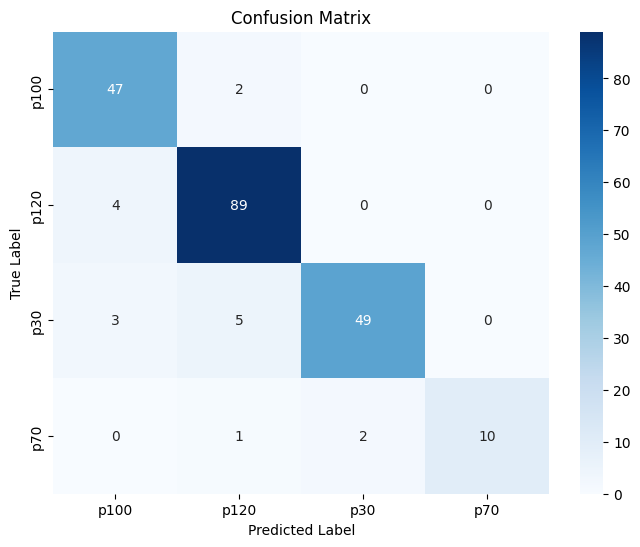

In [59]:
from sklearn.metrics import confusion_matrix
import numpy as np
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt


from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get predictions
y_true = []
y_pred = []

for i in range(len(test_generator)):
    X, y = test_generator[i]
    preds = model_1.predict(X, verbose=0)
    y_pred.extend(preds.argmax(axis=1))
    y_true.extend(y) 


# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# ✅ Use class labels from LabelEncoder
class_labels = label_encoder.classes_

# Plot
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

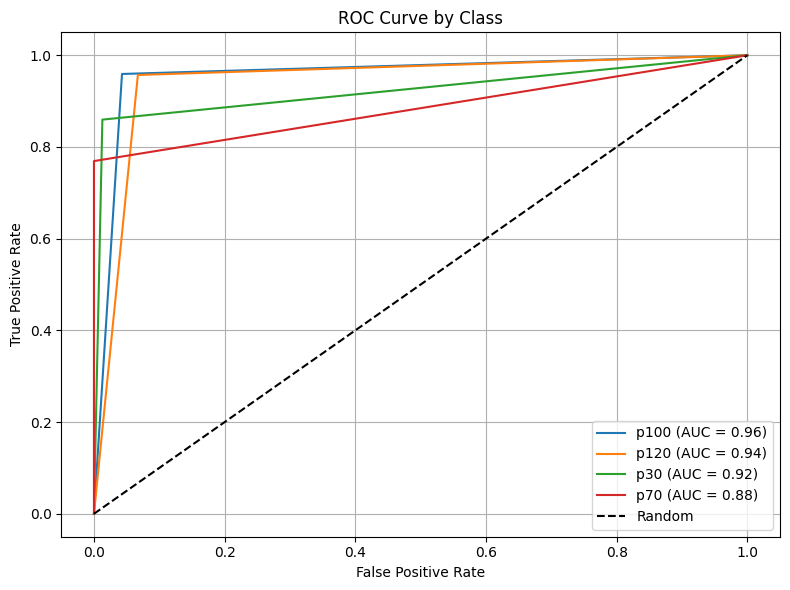


✅ Weighted Average AUC: 0.9385


In [61]:
# Class labels in label encoder order
class_labels = label_encoder.classes_
num_classes = len(class_labels)

# ✅ Convert to one-hot
y_true_one_hot = to_categorical(y_true, num_classes=num_classes)
y_pred_one_hot = to_categorical(y_pred, num_classes=num_classes)

# ✅ Count true samples per class
class_counts = np.sum(y_true_one_hot, axis=0)

# === Plot ROC & Calculate AUC ===
plt.figure(figsize=(8, 6))
AUCs = []

for i, class_name in enumerate(class_labels):
    if class_counts[i] == 0:
        print(f"⚠️ Skipping {class_name} - No true samples.")
        AUCs.append(0)
        continue

    fpr, tpr, _ = roc_curve(y_true_one_hot[:, i], y_pred_one_hot[:, i])
    auc_score = auc(fpr, tpr)
    AUCs.append(auc_score)

    plt.plot(fpr, tpr, label=f"{class_name} (AUC = {auc_score:.2f})")

# Plot diagonal
plt.plot([0, 1], [0, 1], 'k--', label="Random")

# Finalize plot
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve by Class")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

# ✅ Weighted Average AUC
total_samples = np.sum(class_counts)
weighted_AUC = np.sum([AUCs[i] * class_counts[i] for i in range(num_classes)]) / total_samples

print(f"\n✅ Weighted Average AUC: {weighted_AUC:.4f}")


In [63]:
from sklearn.metrics import classification_report, accuracy_score, f1_score,  precision_score

# Compute classification metrics
from sklearn.metrics import classification_report, accuracy_score

report = classification_report(y_true, y_pred, target_names=class_labels)
accuracy = accuracy_score(y_true, y_pred)

# Display results
print("Classification Report:\n", report)
print(f"Accuracy: {accuracy:.2f}")


Classification Report:
               precision    recall  f1-score   support

        p100       0.87      0.96      0.91        49
        p120       0.92      0.96      0.94        93
         p30       0.96      0.86      0.91        57
         p70       1.00      0.77      0.87        13

    accuracy                           0.92       212
   macro avg       0.94      0.89      0.91       212
weighted avg       0.92      0.92      0.92       212

Accuracy: 0.92


In [65]:

# ✅ Generate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Initialize TPR and TNR lists
TPR = []  # Sensitivity
TNR = []  # Specificity

# ✅ Compute TPR and TNR for each class
for i, class_name in enumerate(class_labels):
    TP = conf_matrix[i, i]
    FN = conf_matrix[i, :].sum() - TP
    FP = conf_matrix[:, i].sum() - TP
    TN = conf_matrix.sum() - (TP + FN + FP)

    tpr = TP / (TP + FN) if (TP + FN) != 0 else 0
    tnr = TN / (TN + FP) if (TN + FP) != 0 else 0

    TPR.append(tpr)
    TNR.append(tnr)

    print(f"Class {class_name} - TPR (Sensitivity): {tpr:.2f}, TNR (Specificity): {tnr:.2f}")

# ✅ Compute weighted averages
total_samples = np.sum(class_counts)
weighted_TPR = np.sum([TPR[i] * class_counts[i] for i in range(n_classes)]) / total_samples
weighted_TNR = np.sum([TNR[i] * class_counts[i] for i in range(n_classes)]) / total_samples

# ✅ Display results
print(f"\n✅ Weighted Average TPR (Sensitivity): {weighted_TPR:.2f}")
print(f"✅ Weighted Average TNR (Specificity): {weighted_TNR:.2f}")


Class p100 - TPR (Sensitivity): 0.96, TNR (Specificity): 0.96
Class p120 - TPR (Sensitivity): 0.96, TNR (Specificity): 0.93
Class p30 - TPR (Sensitivity): 0.86, TNR (Specificity): 0.99
Class p70 - TPR (Sensitivity): 0.77, TNR (Specificity): 1.00

✅ Weighted Average TPR (Sensitivity): 0.92
✅ Weighted Average TNR (Specificity): 0.96


In [3]:
import numpy as np
from sklearn.metrics import cohen_kappa_score, mean_absolute_error, mean_squared_error

# Confusion matrix for Vision Transformer (Image model)
conf_matrix_vit = np.array([
    [47, 2, 0, 0],   # True p100 (0)
    [4, 89, 0, 0],   # True p120 (1)
    [3, 5, 49, 0],   # True p30  (2)
    [0, 1, 2, 10]    # True p70  (3)
])

# Generate true and predicted label lists
true_labels_vit = []
pred_labels_vit = []

for true_class in range(conf_matrix_vit.shape[0]):
    for pred_class in range(conf_matrix_vit.shape[1]):
        count = conf_matrix_vit[true_class, pred_class]
        true_labels_vit.extend([true_class] * count)
        pred_labels_vit.extend([pred_class] * count)

# Calculate metrics
kappa_vit = cohen_kappa_score(true_labels_vit, pred_labels_vit)
mae_vit = mean_absolute_error(true_labels_vit, pred_labels_vit)
rmse_vit = mean_squared_error(true_labels_vit, pred_labels_vit, squared=False)

# Relative errors
mean_true_vit = np.mean(true_labels_vit)
rae_vit = np.sum(np.abs(np.array(true_labels_vit) - np.array(pred_labels_vit))) / np.sum(np.abs(np.array(true_labels_vit) - mean_true_vit))
rrse_vit = np.sqrt(np.sum((np.array(true_labels_vit) - np.array(pred_labels_vit))**2) / np.sum((np.array(true_labels_vit) - mean_true_vit)**2))

metrics= {
    "Correctly classified": np.trace(conf_matrix_vit),
    "Incorrectly classified": np.sum(conf_matrix_vit) - np.trace(conf_matrix_vit),
    "Total instances": np.sum(conf_matrix_vit),
    "Kappa statistic": round(kappa_vit, 4),
    "Mean Absolute Error": round(mae_vit, 4),
    "Root Mean Squared Error": round(rmse_vit, 4),
    "Relative Absolute Error (%)": round(rae_vit * 100, 2),
    "Root Relative Squared Error (%)": round(rrse_vit * 100, 2)
}
# Convert to plain Python types
clean_metrics = {k: float(v) if isinstance(v, (np.float32, np.float64)) else int(v) for k, v in metrics.items()}

print(clean_metrics)

{'Correctly classified': 195, 'Incorrectly classified': 17, 'Total instances': 212, 'Kappa statistic': 0.8808, 'Mean Absolute Error': 0.0991, 'Root Mean Squared Error': 0.3699, 'Relative Absolute Error (%)': 14.63, 'Root Relative Squared Error (%)': 43.6}


C:\Users\olanr\anaconda3\envs\pvt_env\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
